In [1]:
import sys
sys.path.append('../utils/')

from utils import *
from TableMapper import TableMapper

from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers = 7)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
query, schema = get_spider_schema_table_files()
tableMapper = TableMapper(query, schema)

In [5]:
res = []
count1 = 0
count2 = 0
count_excess = 0
def get_counts(schemas):
    count1 = 0
    count2 = 0
    count_excess = 0
    i = schemas
    s, t = tableMapper.get_filtered_schema(i)
    count_match, count_all, count_ex = tableMapper.get_exact_match_accuracy(s, t)
    count1 += count_match
    count2 += count_all
    count_excess += count_ex
    if(count1 == 0):
        print(i)

    res = [i, count_match/count_all, len(s), len(t)]
    
    return count1, count2, res, count_excess

In [6]:
%%time
count_df = pd.Series(list(set(schema.schema_id.values))).\
    rename({0 : 'schemas'}).\
    parallel_apply(get_counts)

CPU times: user 399 ms, sys: 147 ms, total: 547 ms
Wall time: 1min 23s


In [7]:
df_results = pd.DataFrame()
df_results[['count1', 'count2', 'res', 'excess_tables']] = pd.DataFrame(pd.DataFrame(count_df)[0].tolist())
df_results

,count1,count2,res,excess_tables
0,11,16,"[station_weather, 0.6875, 4, 16]",0
1,22,29,"[epinions_1, 0.7586206896551724, 4, 29]",0
2,15,15,"[phone_market, 1.0, 3, 15]",0
3,14,36,"[WorldSoccerDataBase, 0.3888888888888889, 2, 36]",1
4,37,48,"[ship_1, 0.7708333333333334, 2, 48]",0
...,...,...,...,...
169,11,15,"[customers_and_products_contacts, 0.7333333333...",0
170,37,40,"[program_share, 0.925, 4, 40]",0
171,13,19,"[flight_company, 0.6842105263157895, 3, 19]",0
172,29,44,"[document_management, 0.6590909090909091, 9, 44]",0


In [9]:
test_schema = 'restaurants'
s, t = tableMapper.get_filtered_schema(test_schema)
count_match, count_all, excess_count = tableMapper.get_exact_match_accuracy(s, t, 1)
print(count_match / count_all, excess_count)

['many', 'buttercup', 'kitchen', 'country', 'city', 'state']
how many buttercup kitchen are there in san francisco ?
SELECT COUNT ( * ) FROM restaurant AS t1 JOIN LOCATION AS t2 ON t1.id  =  t2.restaurant_id WHERE t2.city_name  =  "san francisco" AND t1.name  =  "buttercup kitchen";
['many', 'buttercup', 'kitchen', 'san', 'francisco']
----------------------------------------------------------------------------
Actual List ['location', 'restaurant'] | Predicted List [] 0
----------------------------------------------------------------------------
['many', 'nationality', 'religious', 'political', 'group', 'restaurant', 'nongpe', 'location', 'mountain', 'range', 'body', 'water']
how many chinese restaurants are there in the bay area ?
SELECT COUNT ( * ) FROM restaurant AS t1 JOIN geographic AS t2 ON t1.city_name  =  t2.city_name WHERE t2.region  =  "bay area" AND t1.food_type  =  "chinese";
['many', 'chinese', 'restaurant', 'bay', 'area']
--------------------------------------------------

In [10]:
s

,schema_id,table_name,table_name_original,primary_key,column_list,column_list_original,column_datatypes,foreign_keys
0,restaurants,geographic,GEOGRAPHIC,CITY_NAME,"['city name', 'county', 'region']","['CITY_NAME', 'COUNTY', 'REGION']","['text', 'text', 'text']","[['restaurant', 'CITY_NAME', 'geographic', 'CI..."
1,restaurants,restaurant,RESTAURANT,ID,"['id', 'name', 'food type', 'city name', 'rati...","['ID', 'NAME', 'FOOD_TYPE', 'CITY_NAME', 'RATI...","['number', 'text', 'text', 'text', 'number']",[]
2,restaurants,location,LOCATION,RESTAURANT_ID,"['restaurant id', 'house number', 'street name...","['RESTAURANT_ID', 'HOUSE_NUMBER', 'STREET_NAME...","['number', 'number', 'text', 'text']",[]


0.6344036603999704
0.5474630951217128


,schema_id,score,num_tables,num_queries
0,restaurants,0.008000,3,125
1,scholar,0.022847,10,569
2,baseball_1,0.097561,26,82
3,academic,0.099448,15,181
4,imdb,0.119266,16,109
5,yelp,0.135135,7,111
6,tracking_orders,0.166667,7,60
7,icfp_1,0.196970,4,66
8,products_gen_characteristics,0.197674,6,86
9,local_govt_and_lot,0.235294,11,17


<AxesSubplot:>

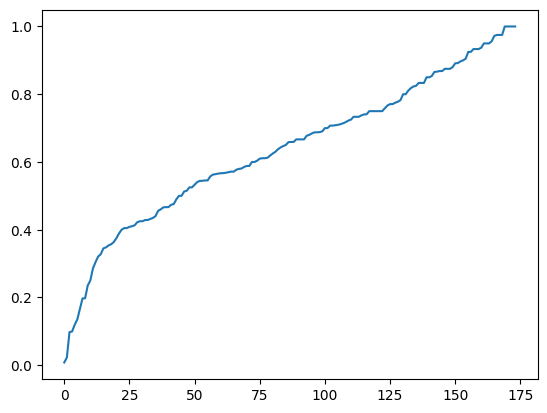

In [11]:
count1 = df_results['count1'].sum()
count2 = df_results['count2'].sum()
score_df = pd.DataFrame(df_results['res'].tolist(), 
                columns = ['schema_id', 'score', 'num_tables', 'num_queries']
            ).sort_values(by = 'score').reset_index(drop = True)
print(score_df.score.mean())
print(count1 / count2)
display(score_df.head(10))
score_df.score.plot()

In [12]:
print(count1)
print(count2)

# 5194
# 9685

# 5223
# 9685

5600
10229
